<a href="https://colab.research.google.com/github/nguyenanhductb23/GeneAlgo-NeuralNet/blob/main/GA_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Giới thiệu

Notebook này là phần thực nghiệm trong bài tập lớn môn Tối ưu hoá với chủ đề "**Thuật toán di truyền trong tối ưu siêu tham số mạng neural**" của nhóm sinh viên Đặng Thành Trung - Nguyễn Anh Đức.

Thuật toán được minh hoạ trên mạng neural có 2 tầng ẩn. Bộ dữ liệu được sử dụng là bộ hình ảnh chữ số viết tay MNIST.

# Import thư viện

In [ ]:
import numpy as np
import random
import math
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load và tiền xử lý dữ liệu

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

11490434/11490434 [==============================] - 0s 0us/step


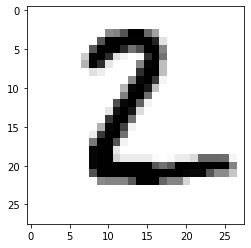

In [ ]:
# Ví dụ về 1 ảnh:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(x_test[1],(28,28)), cmap='gray_r')

# Bước 1: Chọn cấu trúc nhiễm sắc thể biễu diễn lời giải của bài toán

In [ ]:
# Names of the hyperparameters
names = ['hidden_layer_1_size', 'dropout_1', 'hidden_layer_2_size', 'dropout_2', 'learning_rate', 'batch_size']

Cấu trúc NST: Dãy gồm 6 siêu tham số gồm:

- `'hidden_layer_1_size'`: số nguyên, trong khoảng từ 0 đến 200 

- `'dropout_1'`: số thực, trong khoảng 0 đến 1

- `'hidden_layer_2_size'`: số nguyên, trong khoảng từ 0 đến 100

- `'dropout_2'`: số thực, trong khoảng 0 đến 1

- `'learning_rate'`: số thực, trong khoảng từ 0 đến 0.002 

- `'batch_size'`: số nguyên, trong khoảng từ 0 đến 256

Ví dụ: 

` [ hidden_layer_1_size : 130 , dropout_1 : 0.16197944240571338 , hidden_layer_2_size : 19 , dropout_2 : 0.6066713282649048 ,` 
`learning_rate : 0.0011186794632032455 , batch_size : 130 ]`



# Bước 2. Khởi tạo tập lời giải ban đầu

In [ ]:
population = []
init_population_size = 20

for i in range(init_population_size):
    params = np.random.uniform(low=0.0, high=1.0, size=6)
    params[0] *= 200 # Scale the hidden_layer_1_size
    params[2] *= 100 # Scale the hidden_layer_2_size
    params[4] *= 0.002  # Scale the learning rate
    params[5] *= 256  # Scale the batch size
    population.append(params)

# Bước 3. Chọn hàm đánh giá mức độ tốt của lời giải

In [ ]:
def fitness_function(params):
    # Kiến trúc mạng neural
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(int(params[0]), activation='relu', input_shape=(784,)),
        tf.keras.layers.Dropout(params[1]),
        tf.keras.layers.Dense(int(params[2]), activation='relu'),
        tf.keras.layers.Dropout(params[3]),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=min(abs(params[4]),0.1)),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train + Evaluate
    model.fit(x_train, y_train, epochs=5, batch_size=int(params[5]), verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)


print('Model with [', names[0], ':', int(params[0]), ',', names[1], ':', params[1], ',',
           names[2], ':', int(params[2]), ',', names[3], ':', params[3], ',',
           names[4], ':', params[4], ',', names[5], ':', int(params[5]), ']:\n',
            'Accuracy:', accuracy)
    
    return accuracy

# Bước 4. Thiết kế các toán tử di truyền


## Thủ tục chọn lọc

In [ ]:
def roulette_wheel_selection(fitness_scores):
    min_fitness = min(fitness_scores)
    fitness_scores1 = []
    for i in range(len(fitness_scores)):
        fitness_scores1.append(fitness_scores[i] - min_fitness)
    total_fitness = sum(fitness_scores1)

    # Tính tổng tích lũy điểm số
    cumulative_fitness = [sum(fitness_scores1[:i+1])/total_fitness 
                            for i in range(len(fitness_scores))]
    # Lựa chọn một vị trí ngẫu nhiên dựa trên tổng tích lũy
    r = random.random()
    for i in range(len(cumulative_fitness)):
        if r < cumulative_fitness[i]:
            return i

## Toán tử tương giao chéo

In [ ]:
def crossover(parent1, parent2, crossover_rate):
    child = parent1.copy()
    for j in range(len(child)):
        if random.random() < crossover_rate:
            child[j] = parent2[j]
    return child

## Toán tử biến dị

In [ ]:
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = abs(random.normalvariate
                                   (individual[i], 0.1*individual[i]))
    return individual

# Bước 5: Xác định các tham số cho bài toán

In [ ]:
population_size = 15
crossover_rate = 0.8
mutation_rate = 0.1
generations = 4

# Quá trình tiến hoá

In [ ]:
for generation in range(generations):
    print('GENERATION', generation)
    # Đánh giá độ thích nghi của các cá thể 
    fitness_scores = [fitness_function(params) for params in population]
    
    # Lai ghép và biến dị các cá thể đã chọn để tạo ra quần thể mới
    new_population = []
    for i in range(population_size):
        parent1 = population[roulette_wheel_selection(fitness_scores)]
        parent2 = population[roulette_wheel_selection(fitness_scores)]
        child = crossover(parent1, parent2, crossover_rate)
        child = mutate(child, mutation_rate)
        new_population.append(child)
        
    # Thay thế quần thể cũ bằng quần thể mới
    population = new_population

# Chọn mô hình tốt nhất
fitness_scores = [fitness_function(params) for params in population]
best_params = population[np.argmax(fitness_scores)]

GENERATION 0
Model with [ hidden_layer_1_size : 154 , dropout_1 : 0.8941046964130716 , hidden_layer_2_size : 32 , dropout_2 : 0.8373702870741396 , learning_rate : 0.0006712483783370431 , batch_size : 153 ]:
 Accuracy:  0.8086000084877014
Model with [ hidden_layer_1_size : 11 , dropout_1 : 0.5072520776473347 , hidden_layer_2_size : 87 , dropout_2 : 0.9921409071846675 , learning_rate : 0.001356675481209571 , batch_size : 176 ]:
 Accuracy:  0.11349999904632568
Model with [ hidden_layer_1_size : 26 , dropout_1 : 0.057745181205076435 , hidden_layer_2_size : 20 , dropout_2 : 0.7974346167604696 , learning_rate : 0.0014003355768476267 , batch_size : 114 ]:
 Accuracy:  0.9302999973297119
Model with [ hidden_layer_1_size : 183 , dropout_1 : 0.5700152782085914 , hidden_layer_2_size : 10 , dropout_2 : 0.10163010278578755 , learning_rate : 0.00032497263243530994 , batch_size : 139 ]:
 Accuracy:  0.9452000260353088
Model with [ hidden_layer_1_size : 134 , dropout_1 : 0.6118608931154854 , hidden_laye

# Sử dụng mô hình

In [ ]:
print('BEST MODEL: ')
print('Model with [', names[0], ':', int(best_params[0]), ',', names[1], ':', best_params[1], ',',
           names[2], ':', int(best_params[2]), ',', names[3], ':', best_params[3], ',',
           names[4], ':', best_params[4], ',', names[5], ':', int(best_params[5]), ']:\n')
 
model = tf.keras.models.Sequential([
tf.keras.layers.Dense(best_params[0], activation='relu', input_shape=(784,)),
tf.keras.layers.Dropout(best_params[1]),
tf.keras.layers.Dense(best_params[2], activation='relu'),
tf.keras.layers.Dropout(best_params[3]),
tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params[4]),
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=8, batch_size=int(best_params[5]))
print("Test")
loss, accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

BEST MODEL: 
Model with [ hidden_layer_1_size : 187 , dropout_1 : 0.16197944240571338 , hidden_layer_2_size : 37 , dropout_2 : 0.10163010278578755 , learning_rate : 0.0013312232572304278 , batch_size : 114 ]:

Epoch 1/8
527/527 [==============================] - 3s 5ms/step - loss: 0.3538 - accuracy: 0.8956
Epoch 2/8
527/527 [==============================] - 2s 4ms/step - loss: 0.1573 - accuracy: 0.9536
Epoch 3/8
527/527 [==============================] - 2s 4ms/step - loss: 0.1119 - accuracy: 0.9657
Epoch 4/8
527/527 [==============================] - 2s 4ms/step - loss: 0.0938 - accuracy: 0.9713
Epoch 5/8
527/527 [==============================] - 2s 4ms/step - loss: 0.0797 - accuracy: 0.9750
Epoch 6/8
527/527 [==============================] - 3s 6ms/step - loss: 0.0689 - accuracy: 0.9777
Epoch 7/8
527/527 [==============================] - 2s 4ms/step - loss: 0.0597 - accuracy: 0.9805
Epoch 8/8
527/527 [==============================] - 2s 4ms/step - loss: 0.0554 - accuracy: 0.982